In [1]:
#Leer el archivo results.txt linea por linea
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lcp.src.problems.problems import Problems
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300


results = []
with open('results.txt', 'r', encoding='utf-8', newline='\n') as r: 
    for line in r:
        json_line = json.loads(line)
        results.append(json_line)
        
problems = {}
for i in [5,10,20]:
    ps = Problems(file_path='problems/types_%d.json' % i).load_problems()
    for p in ps:
        if i not in problems:
            problems[i] = {}
        problems[i][p.id] = p

mejoras = {
    "none": "M0",
    "during":"M1",
    "late_all":"M2",
    "late_some":"M3",
    "late_best":"M4"
}

winners = {}
for i in range(0, len(results), 5):
    result_part = results[i:i+5]
    best_group = max(result_part, key=lambda pair: pair['best_value'][2])
    
    types_count = "%sT" % best_group['types_count']
    group_improvement = mejoras[best_group['group_improvement']]
    
    if group_improvement not in winners:
        winners[group_improvement] = 0
    #if group_improvement not in winners[types_count]:
    #    winners[types_count][group_improvement] = 0
    winners[group_improvement] += 1
winners

{'M2': 43, 'M1': 68, 'M4': 11, 'M0': 6, 'M3': 22}

In [2]:
from numpy import floor


evolution = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in evolution:
        evolution[types_count] = {}
    if group_improvement not in evolution[types_count]:
        evolution[types_count][group_improvement] = []

    x = [floor(x*10)/10 for x in [0]+r['timings']['generations_time']]
    y = [round(100*((v/r['best_values'][0]) - 1), 10)
         for v in r['best_values']]

    evolution[types_count][group_improvement].append(pd.Series(y, index=x))

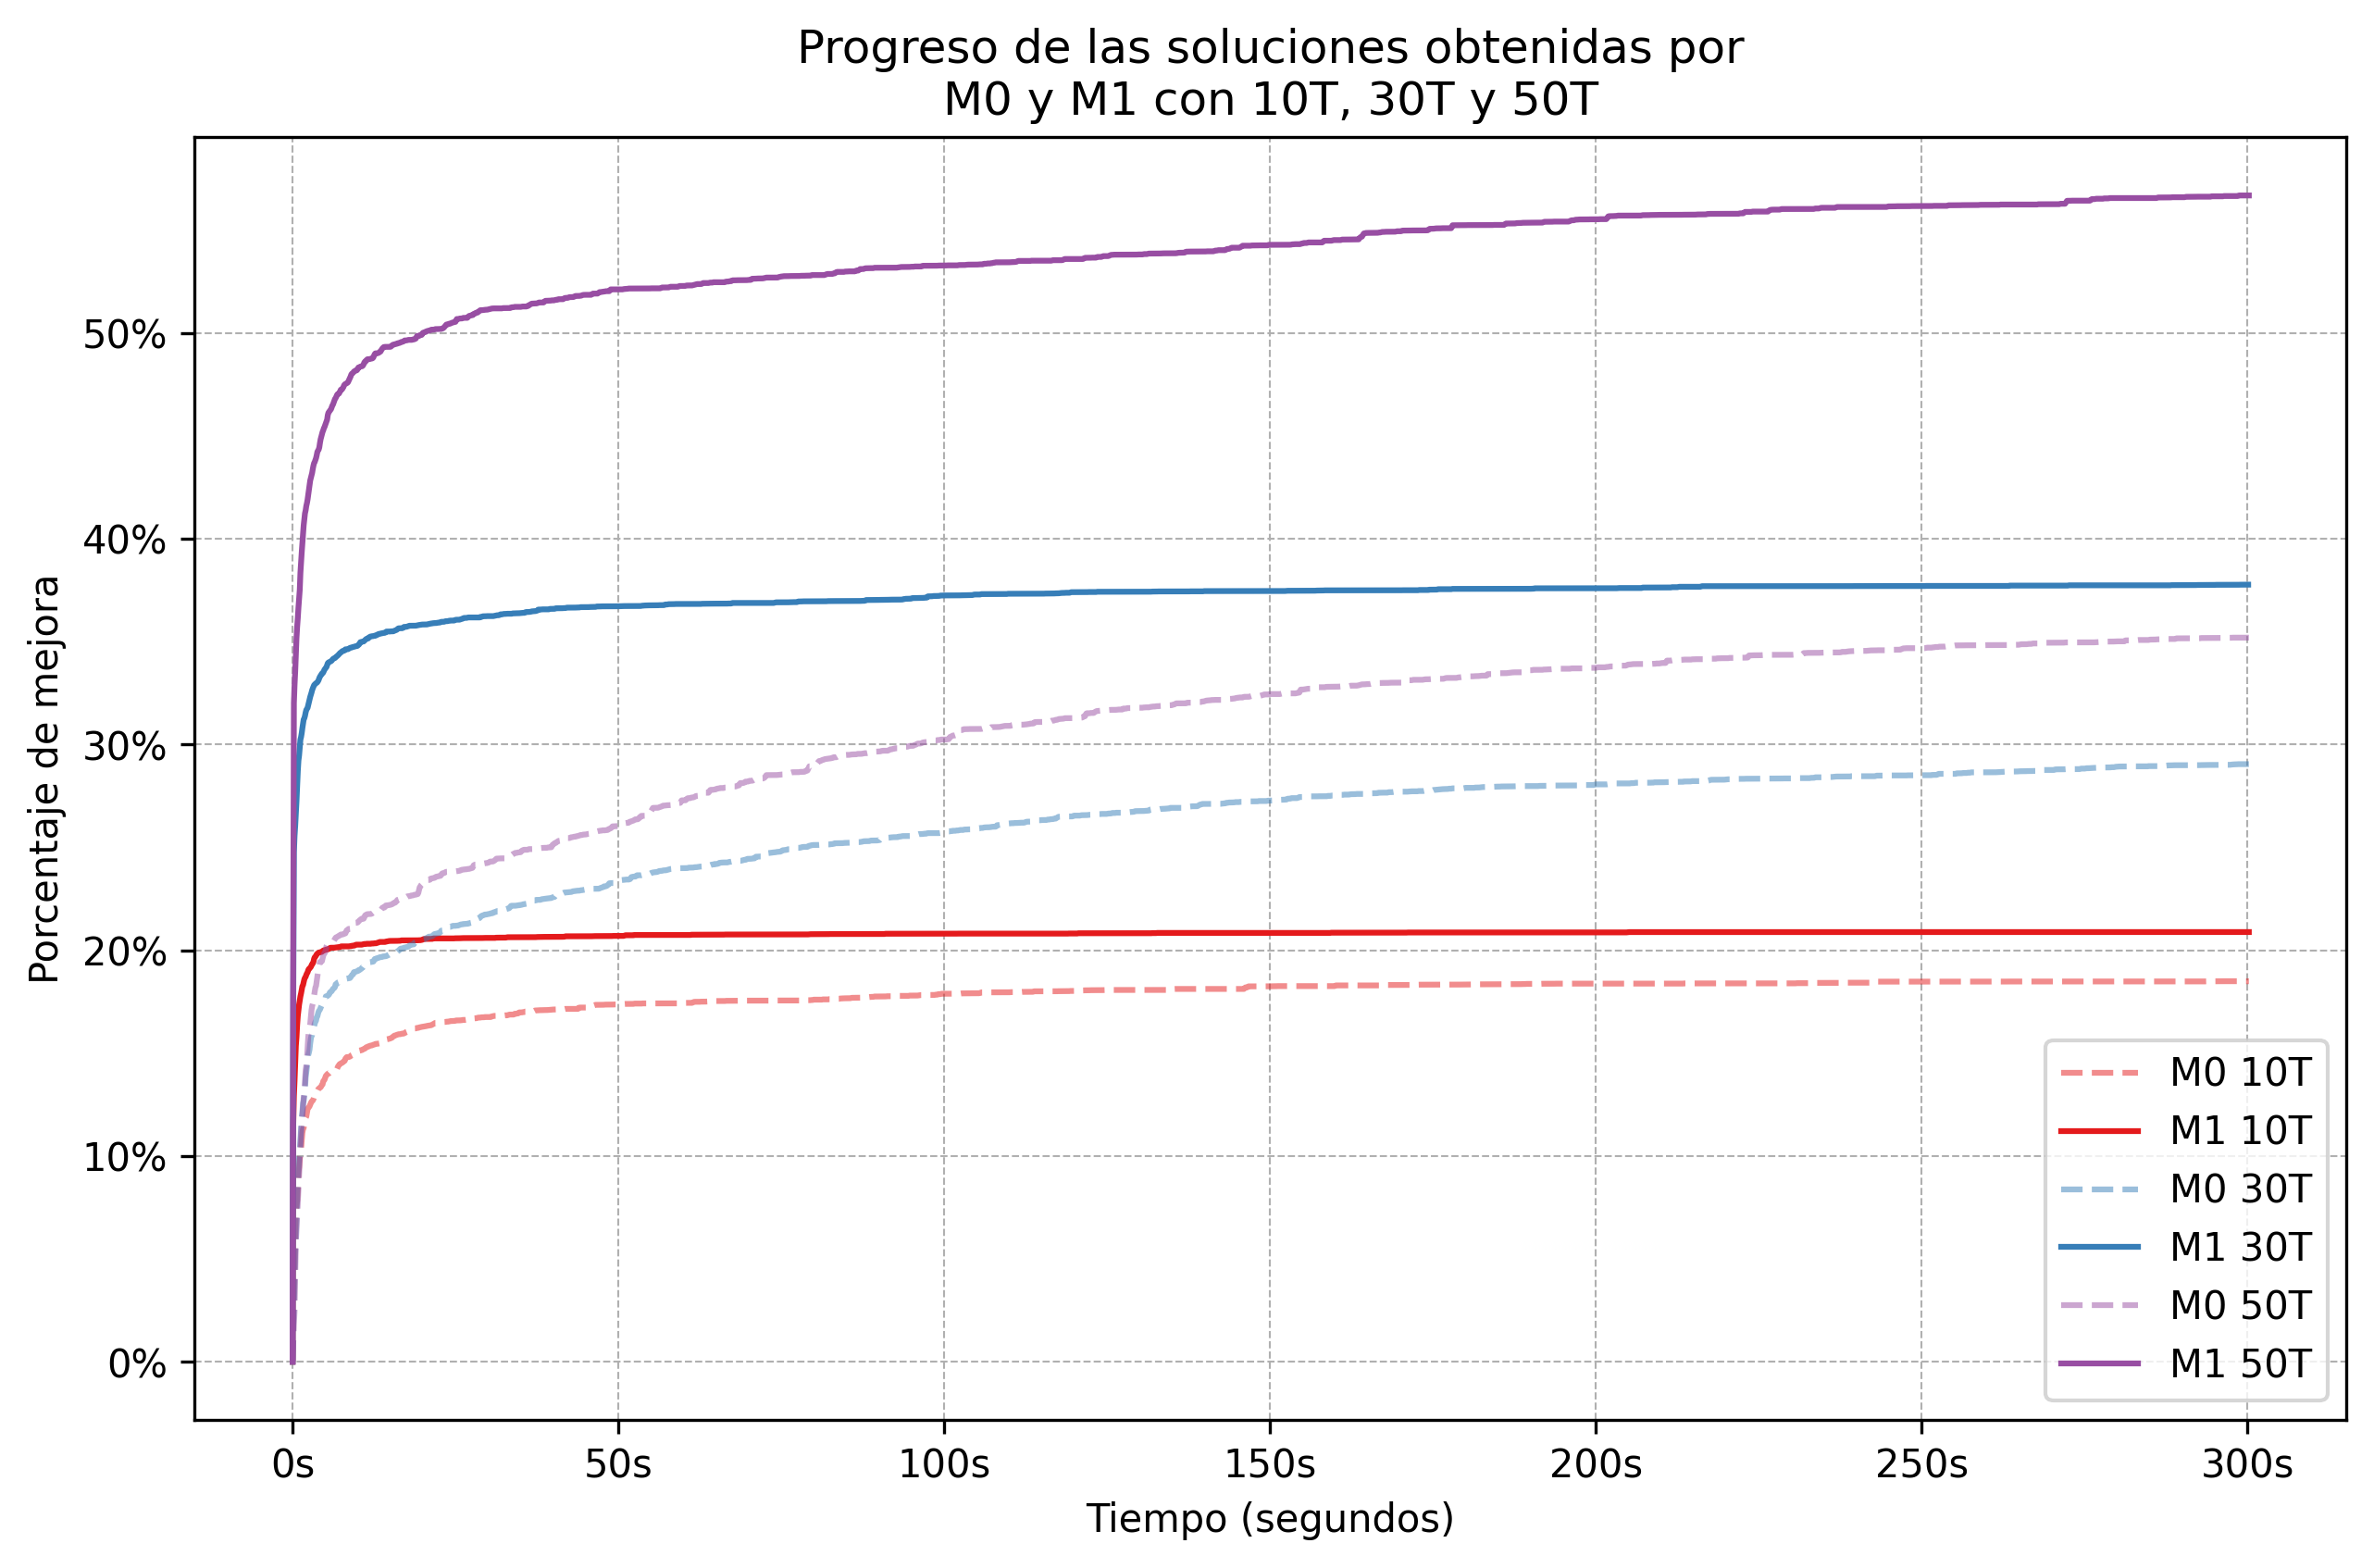

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(10, 6))
sns_colors = sns.color_palette('Set1', n_colors=8)
colors = {
    '10T': sns_colors[0],
    '30T': sns_colors[1],
    '50T': sns_colors[3]
}
for types_count in evolution:
    for group_improvement in evolution[types_count]:
        if group_improvement in ['M0', 'M1'] and types_count in ['10T', '30T', '50T']:
            data = evolution[types_count][group_improvement]
            data = [d.loc[~d.index.duplicated(keep='first')] for d in data]
            data = [d.loc[d.index <= 600.0] for d in data]

            df = pd.concat(data, axis=1)
            df = df.sort_index()
            df_interpolated = pd.concat(
                [df[col].interpolate(method='linear') for col in df], axis=1)

            mean = df_interpolated.mean(axis=1).round(6)
            ax.plot(mean.index, mean, label=group_improvement + ' ' + types_count,
                    color=colors[types_count],
                    linestyle='--' if group_improvement == 'M0' else '-',
                    alpha=0.5 if group_improvement == 'M0' else 1)

# Configuración de los ejes
ax.set_xlabel('Tiempo (segundos)')
ax.set_ylabel('Porcentaje de mejora')
ax.set_title('Progreso de las soluciones obtenidas por\nM0 y M1 con 10T, 30T y 50T')

# Formateo del eje x
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}s'.format(x)))
xticks = [1, 60, 120, 180, 240, 300, 600]
# ax.set_xticks(xticks)
# ax.set_xticklabels(['{}s'.format(x) for x in xticks])

# Formateo del eje y
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

plt.grid(True, linestyle='--', linewidth=0.5)

# Añadiendo la leyenda
ax.legend(loc='best')
plt.savefig('./lcp/document/Figures/progreso.svg', format='svg')
# Mostrar el gráfico
plt.show()

In [4]:
improvements = {

}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in improvements:
        improvements[types_count] = {}
    if group_improvement not in improvements[types_count]:
        improvements[types_count][group_improvement] = []
    improvements[types_count][group_improvement].append(
        100*(r['best_value'][0]/r['default_max_fitness'][0]-1))

for i, im in improvements.items():
    for j in improvements[i]:
        improvements[i][j] = [round(np.mean(improvements[i][j]), 1), round(
            np.std(improvements[i][j]), 1)]
    print(("%s & " % i) + " & ".join(["%s\\%% & %s" % (x, y)
          for x, y in improvements[i].values()]) + " \\\\ \\hline")
# improvements

5T & 9.3\% & 3.7 & 10.5\% & 4.1 & 10.4\% & 4.1 & 10.0\% & 4.1 & 9.9\% & 4.1 \\ \hline
10T & 18.5\% & 6.0 & 20.9\% & 6.1 & 20.6\% & 5.9 & 20.2\% & 6.1 & 19.0\% & 5.9 \\ \hline
20T & 27.2\% & 6.5 & 33.1\% & 6.6 & 32.1\% & 6.5 & 31.6\% & 6.6 & 28.3\% & 7.0 \\ \hline
30T & 29.0\% & 7.8 & 37.8\% & 8.7 & 37.2\% & 8.9 & 34.9\% & 7.9 & 31.8\% & 8.1 \\ \hline
40T & 28.6\% & 8.3 & 44.5\% & 9.8 & 43.1\% & 10.1 & 42.2\% & 9.8 & 35.1\% & 9.7 \\ \hline
50T & 35.2\% & 9.4 & 56.7\% & 12.6 & 54.6\% & 12.5 & 52.1\% & 13.2 & 46.4\% & 12.3 \\ \hline


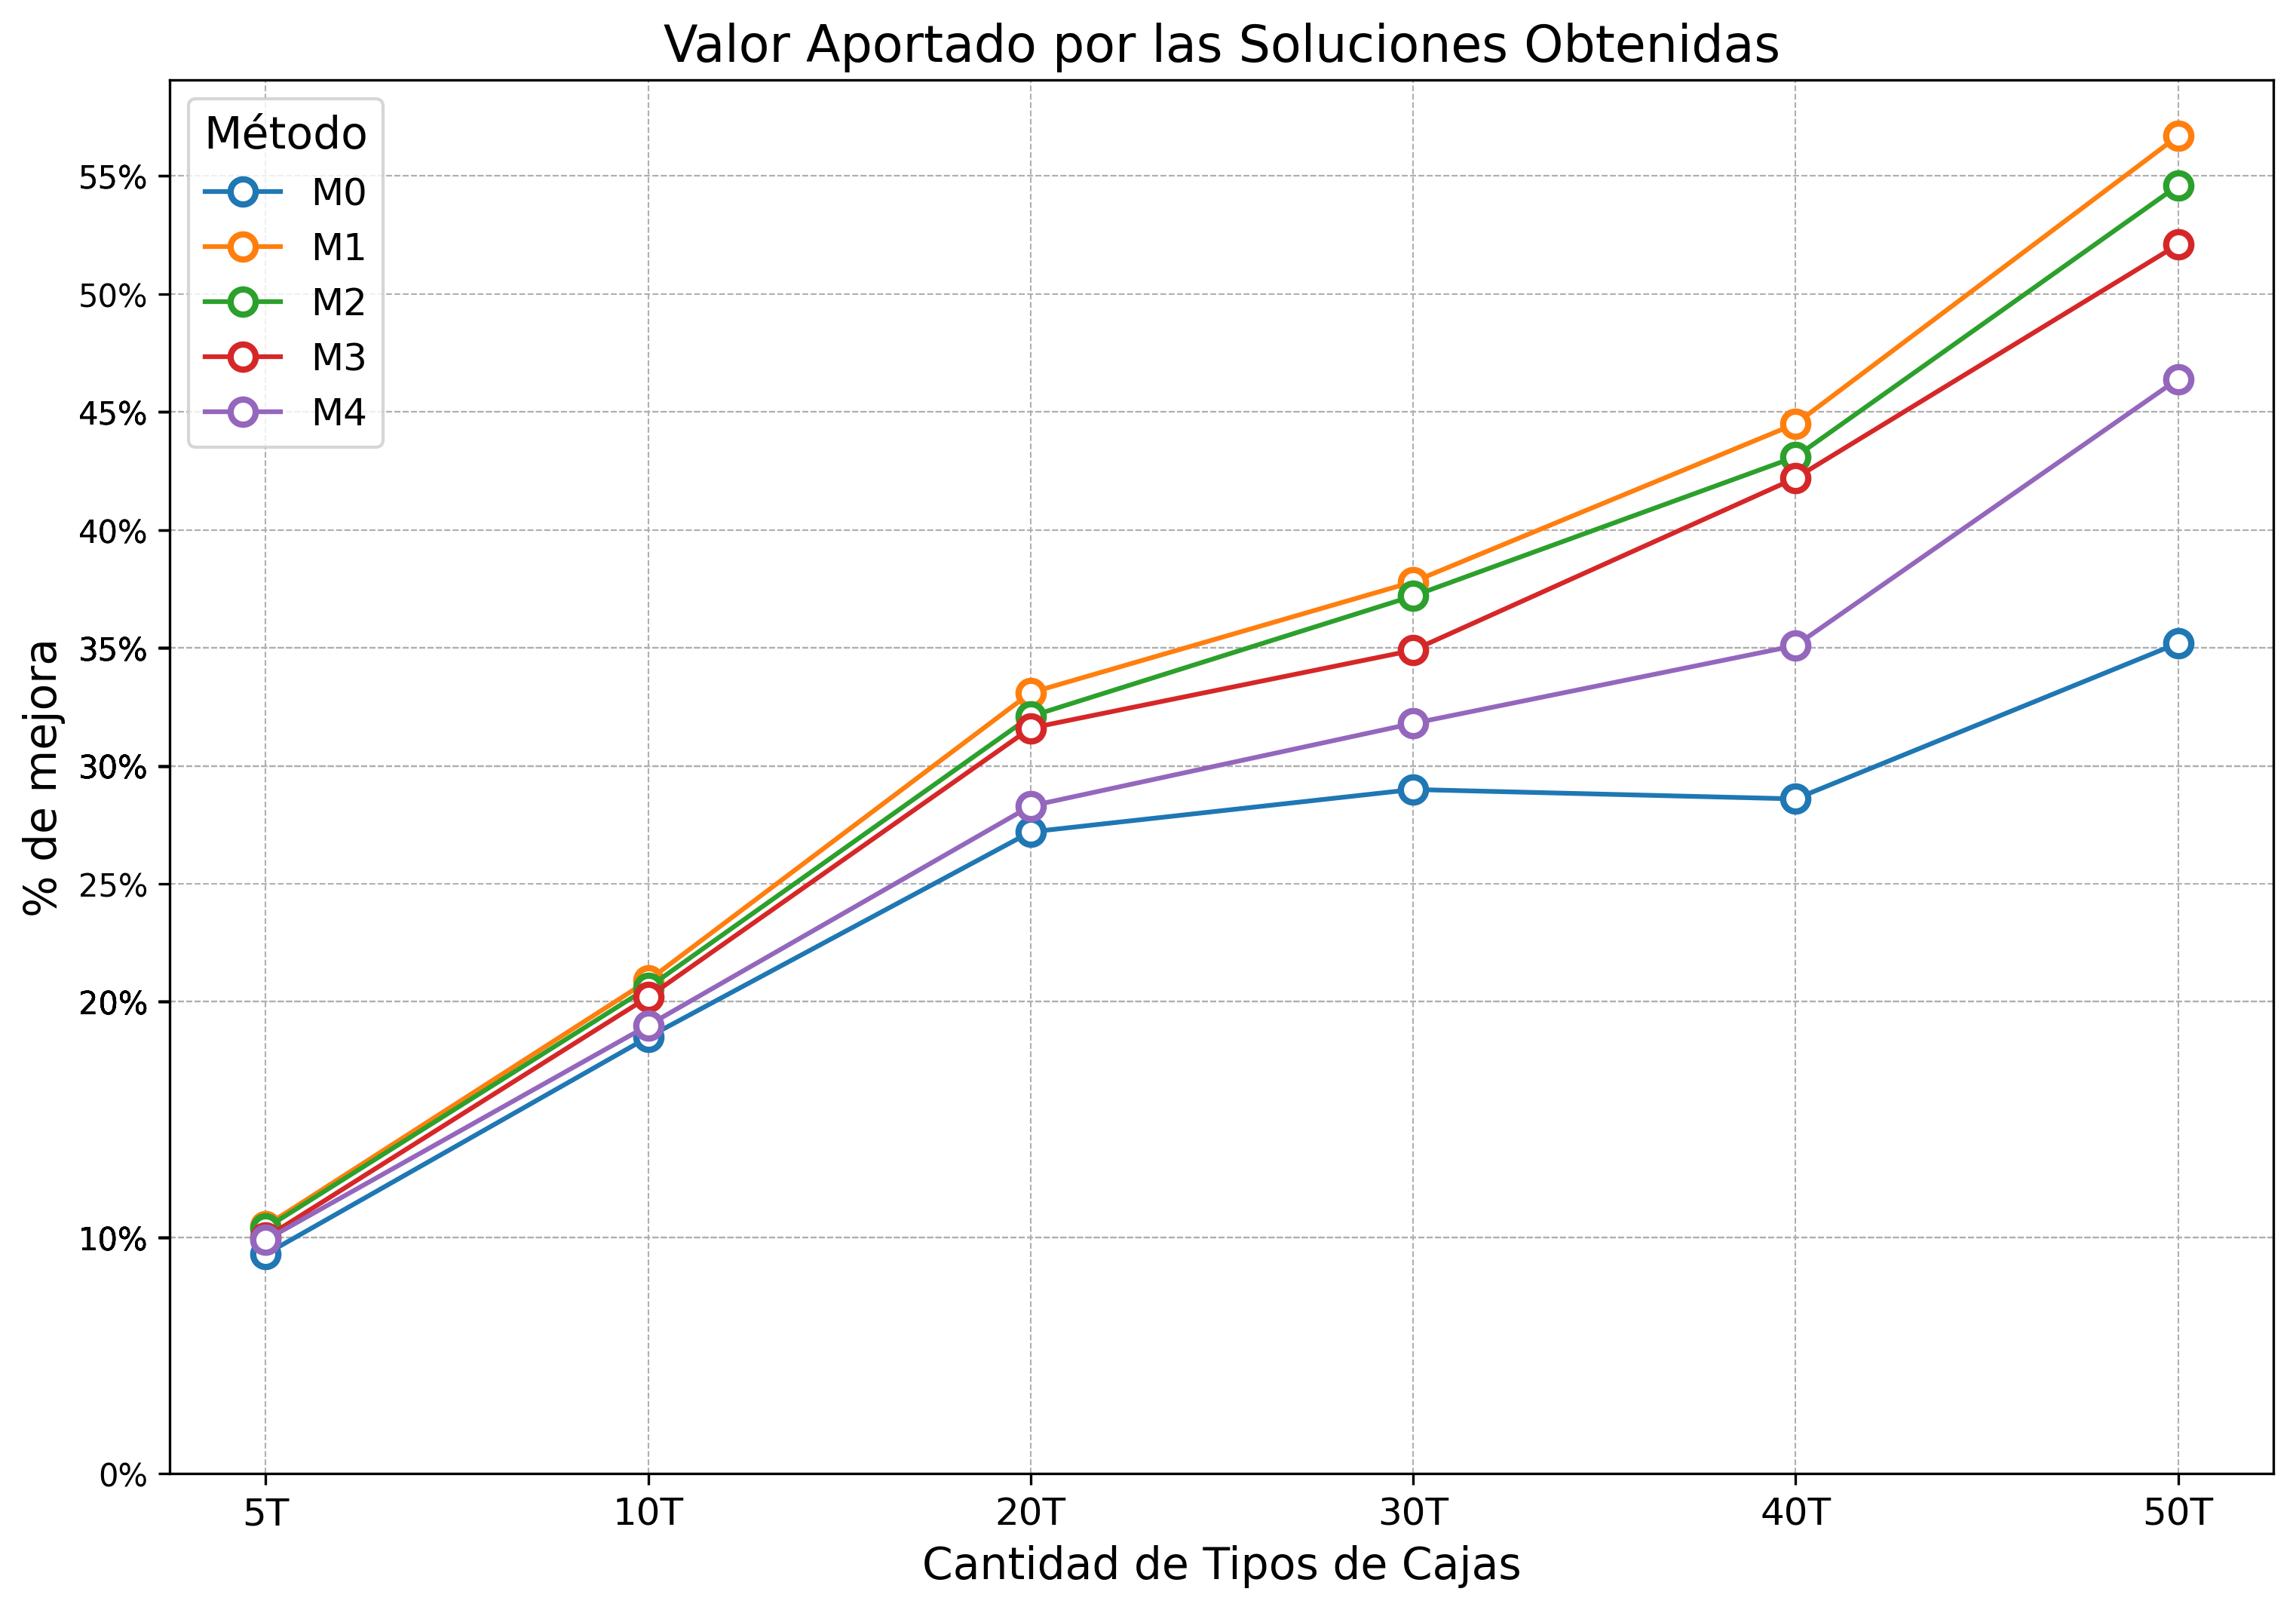

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick


# Suponiendo que los datos están en la variable `timings`
data = improvements

# Inicializar listas para el eje x (claves) y el eje y (promedios)
x = list(data.keys())
none_averages = [data[k]['M0'][0] for k in x]
during_averages = [data[k]['M1'][0] for k in x]
late_all_averages = [data[k]['M2'][0] for k in x]
late_best_averages = [data[k]['M3'][0] for k in x]
late_some_averages = [data[k]['M4'][0] for k in x]

# Definir colores para cada serie
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear la figura y los ejes con el tamaño especificado
fig, ax = plt.subplots(figsize=(12, 8))
# Plotear los datos con mejoras estéticas
plt.plot(x, none_averages, label='M0', marker='o', linestyle='-', color=colors[0], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, during_averages, label='M1', marker='o', linestyle='-', color=colors[1], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_all_averages, label='M2', marker='o', linestyle='-', color=colors[2], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_best_averages, label='M3', marker='o', linestyle='-', color=colors[3], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_some_averages, label='M4', marker='o', linestyle='-', color=colors[4], markersize=8, markerfacecolor='white', markeredgewidth=2)

# Añadir títulos y etiquetas con mayor detalle
plt.title('Valor Aportado por las Soluciones Obtenidas', fontsize=16)
plt.xlabel('Cantidad de Tipos de Cajas', fontsize=14)
plt.ylabel('% de mejora', fontsize=14)

# Añadir la leyenda
plt.legend(title='Método', fontsize=12, title_fontsize=14)

# Añadir rejilla con estilo
plt.grid(True, linestyle='--', linewidth=0.5)

# Mejorar la visualización de los ejes
plt.xticks(fontsize=12)
fmt = '%.0f%%' # Cambia a la precisión que necesites
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
y_values = [0.1] + none_averages + during_averages + late_all_averages + late_best_averages + late_some_averages
# Usar la función set_yticks para establecer los ticks en el eje y
plt.yticks([5*round(y/5,0) for y in y_values])
plt.savefig('./lcp/document/Figures/improvement.svg', format='svg')
# Mostrar el gráfico
plt.show()
#Guardar el svg

In [6]:
timings = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in timings:
        timings[types_count] = {}
    if group_improvement not in timings[types_count]:
        timings[types_count][group_improvement] = []
    timings[types_count][group_improvement].append(r['best']['best_time'])

timings_text = {}
for i, im in timings.items():
    for j in timings[i]:
        if i not in timings_text:
            timings_text[i] = {}
        if j not in timings_text[i]:
            timings_text[i][j] = []
        timings_text[i][j] = [round(np.mean(timings[i][j]), 1), round(
            np.std(timings[i][j]), 1)]
    print(("%s & " % i) + " & ".join(["%s & %s" % (x, y)
         for x, y in timings_text[i].values()]) + " \\\\ \\hline")
#timings

5T & 71.4 & 72.4 & 23.7 & 47.6 & 56.9 & 71.1 & 33.6 & 63.5 & 39.3 & 47.9 \\ \hline
10T & 146.0 & 85.3 & 72.5 & 69.2 & 102.1 & 87.9 & 61.1 & 59.8 & 117.5 & 85.8 \\ \hline
20T & 214.4 & 56.4 & 89.0 & 72.6 & 145.9 & 62.6 & 188.0 & 79.7 & 166.8 & 70.8 \\ \hline
30T & 263.1 & 36.3 & 183.8 & 73.9 & 175.4 & 81.9 & 186.8 & 70.4 & 231.9 & 48.9 \\ \hline
40T & 266.2 & 34.0 & 208.4 & 70.0 & 224.0 & 50.9 & 244.0 & 49.1 & 238.3 & 54.2 \\ \hline
50T & 257.0 & 42.6 & 244.3 & 49.2 & 228.5 & 61.3 & 251.7 & 36.4 & 250.5 & 51.6 \\ \hline


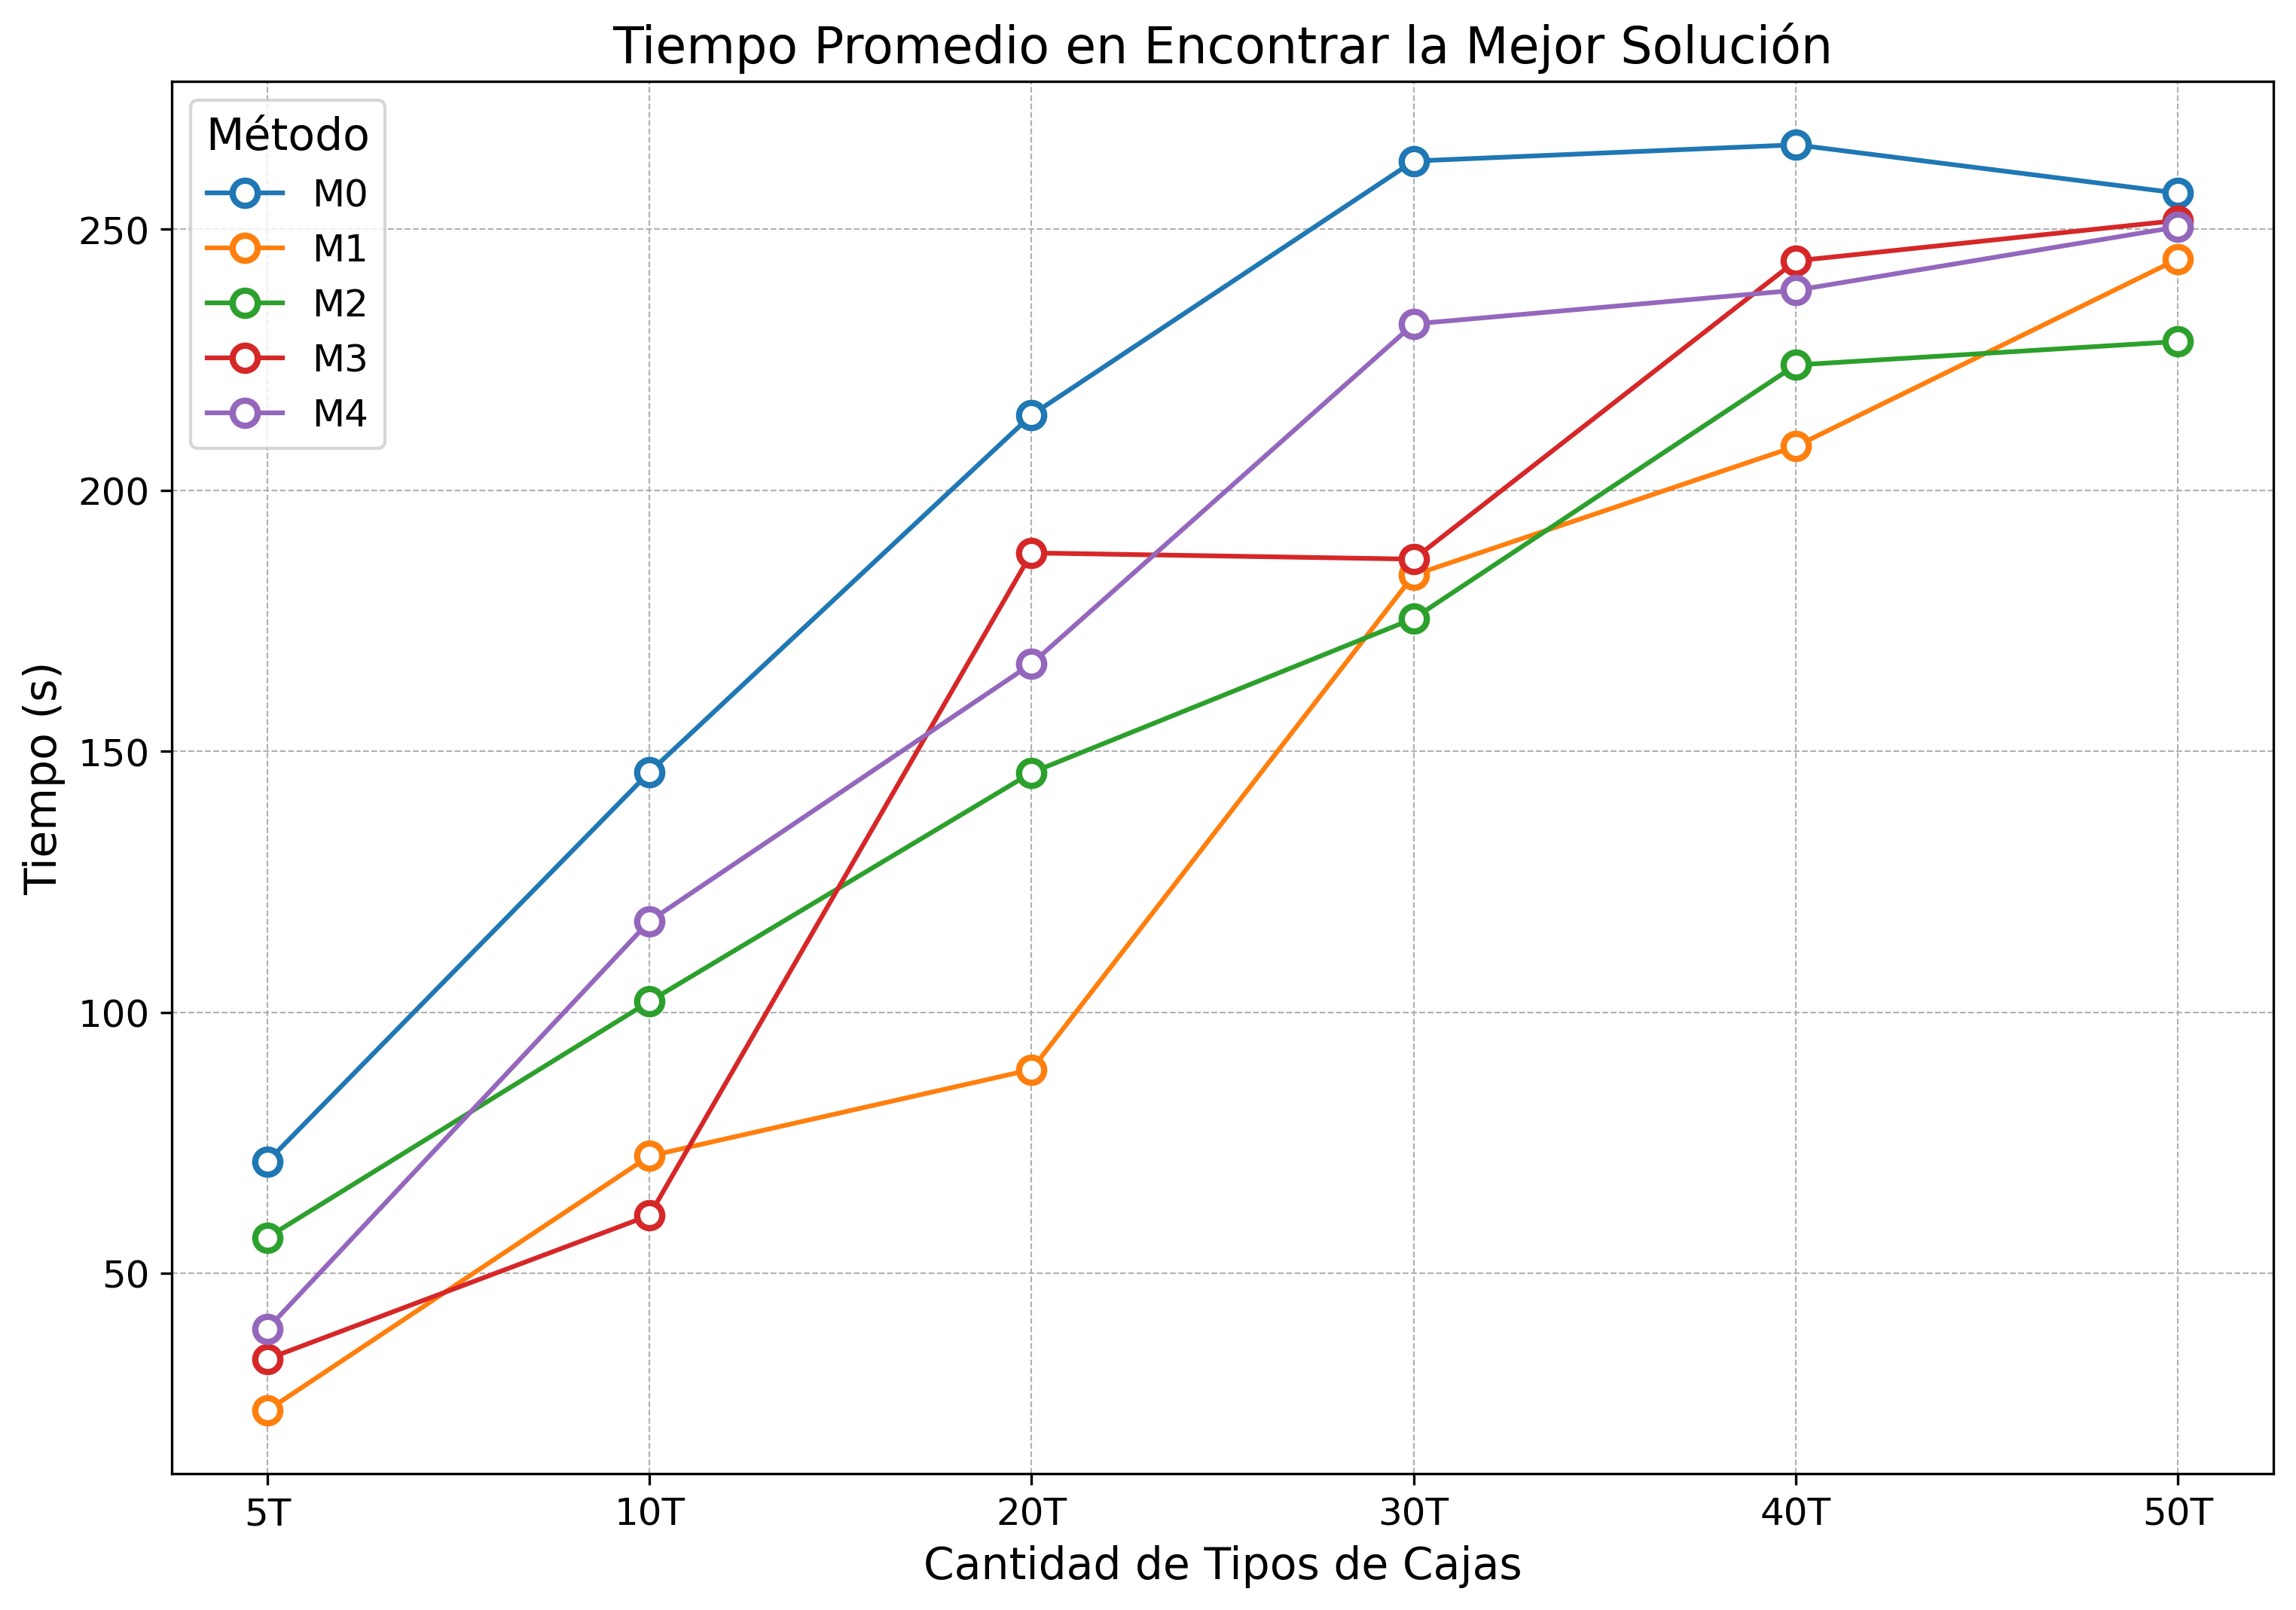

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que los datos están en la variable `timings`
data = timings

# Inicializar listas para el eje x (claves) y el eje y (promedios)
x = list(data.keys())
none_averages = [np.mean(data[k]['M0']) for k in x]
during_averages = [np.mean(data[k]['M1']) for k in x]
late_all_averages = [np.mean(data[k]['M2']) for k in x]
late_best_averages = [np.mean(data[k]['M3']) for k in x]
late_some_averages = [np.mean(data[k]['M4']) for k in x]

# Definir colores para cada serie
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Plotear los datos con mejoras estéticas
plt.plot(x, none_averages, label='M0', marker='o', linestyle='-', color=colors[0], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, during_averages, label='M1', marker='o', linestyle='-', color=colors[1], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_all_averages, label='M2', marker='o', linestyle='-', color=colors[2], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_best_averages, label='M3', marker='o', linestyle='-', color=colors[3], markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.plot(x, late_some_averages, label='M4', marker='o', linestyle='-', color=colors[4], markersize=8, markerfacecolor='white', markeredgewidth=2)

# Añadir títulos y etiquetas con mayor detalle
plt.title('Tiempo Promedio en Encontrar la Mejor Solución', fontsize=16)
plt.xlabel('Cantidad de Tipos de Cajas', fontsize=14)
plt.ylabel('Tiempo (s)', fontsize=14)

# Añadir la leyenda
plt.legend(title='Método', fontsize=12, title_fontsize=14)

# Añadir rejilla con estilo
plt.grid(True, linestyle='--', linewidth=0.5)

# Mejorar la visualización de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./lcp/document/Figures/tiempos.svg', format='svg')
# Mostrar el gráfico
plt.show()
#Guardar el svg


In [8]:
performance = {}
stop_time = 120
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in performance:
        performance[types_count] = {}
    if group_improvement not in performance[types_count]:
        performance[types_count][group_improvement] = []

    num_generation_stop = len(
        list(filter(lambda x: x <= stop_time, r['timings']['generations_time'])))
    best_value_at_stop = r['best_values'][num_generation_stop]
    # performance[types_count][group_improvement].append(
    #    (100*(r['best_value'][0]/r['default_max_fitness'][0]-1))/r['best']['best_time'])
    performance[types_count][group_improvement].append(
        (100*((best_value_at_stop/r['default_max_fitness'][0])-1))/stop_time)

performance_text = {}
for i, im in performance.items():
    for j in performance[i]:
        if i not in performance_text:
            performance_text[i] = {}
        if j not in performance_text[i]:
            performance_text[i][j] = []
        performance_text[i][j] = [round(np.mean(performance[i][j]), 1), round(
            np.std(performance[i][j]), 1)]
# performance_text

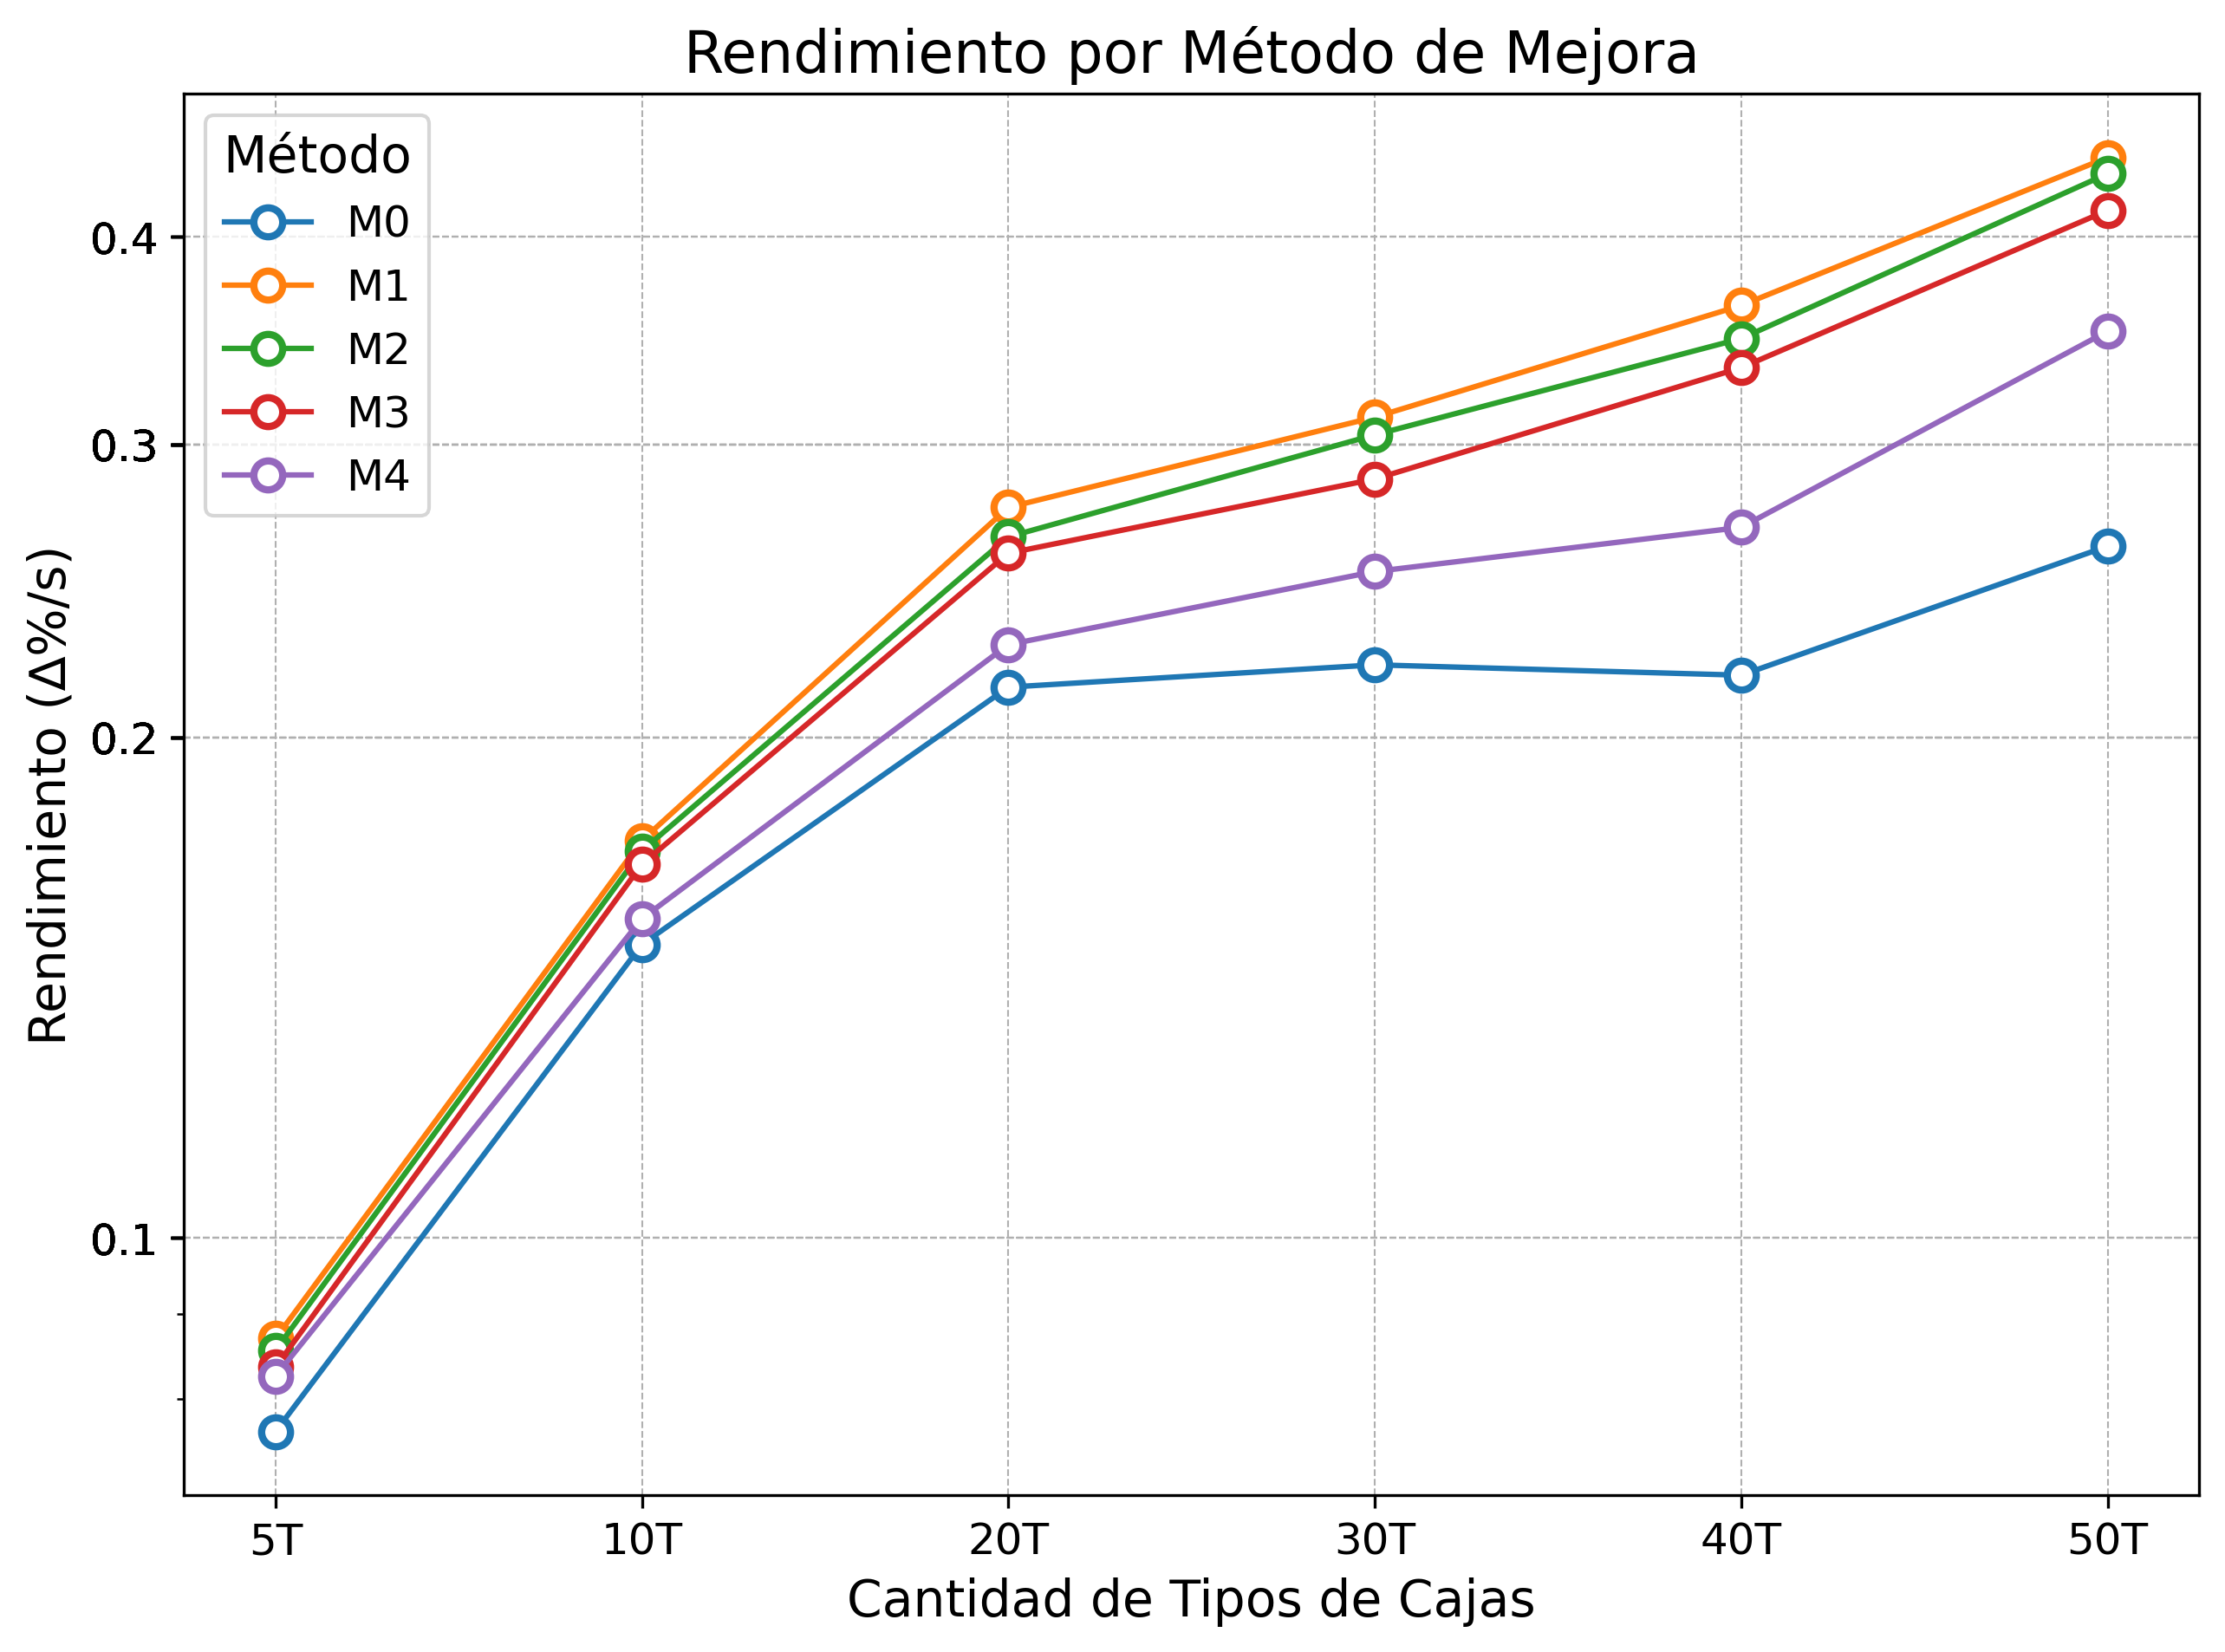

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Suponiendo que los datos están en la variable `timings`
data = performance

# Inicializar listas para el eje x (claves) y el eje y (promedios)
x = list(data.keys())
none_averages = [np.mean(data[k]['M0']) for k in x]
during_averages = [np.mean(data[k]['M1']) for k in x]
late_all_averages = [np.mean(data[k]['M2']) for k in x]
late_best_averages = [np.mean(data[k]['M3']) for k in x]
late_some_averages = [np.mean(data[k]['M4']) for k in x]

# Definir colores para cada serie
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 7))

# Plotear los datos con mejoras estéticas
ax.plot(x, none_averages, label='M0', marker='o', linestyle='-', color=colors[0], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, during_averages, label='M1', marker='o', linestyle='-', color=colors[1], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_all_averages, label='M2', marker='o', linestyle='-', color=colors[2], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_best_averages, label='M3', marker='o', linestyle='-', color=colors[3], markersize=8, markerfacecolor='white', markeredgewidth=2)
ax.plot(x, late_some_averages, label='M4', marker='o', linestyle='-', color=colors[4], markersize=8, markerfacecolor='white', markeredgewidth=2)

# Añadir títulos y etiquetas con mayor detalle
ax.set_title('Rendimiento por Método de Mejora', fontsize=16)
ax.set_xlabel('Cantidad de Tipos de Cajas', fontsize=14)
ax.set_ylabel('Rendimiento (∆%/s)', fontsize=14)

# Añadir la leyenda
ax.legend(title='Método', fontsize=12, title_fontsize=14)

# Añadir rejilla con estilo
ax.grid(True, linestyle='--', linewidth=0.5)

# Mejorar la visualización de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Hacer el eje y logarítmico
ax.set_yscale("log")

# Cambiar las etiquetas del eje y a su forma exponencial
formatter = ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
# Obtener los valores y de los puntos
y_values = [0.1] + none_averages + during_averages + late_all_averages + late_best_averages + late_some_averages
# Usar la función set_yticks para establecer los ticks en el eje y
ax.set_yticks([round(y,1) for y in y_values])
plt.savefig('./lcp/document/Figures/rendimiento.svg', format='svg')
# Mostrar el gráfico
plt.show()
#Guardar el svg


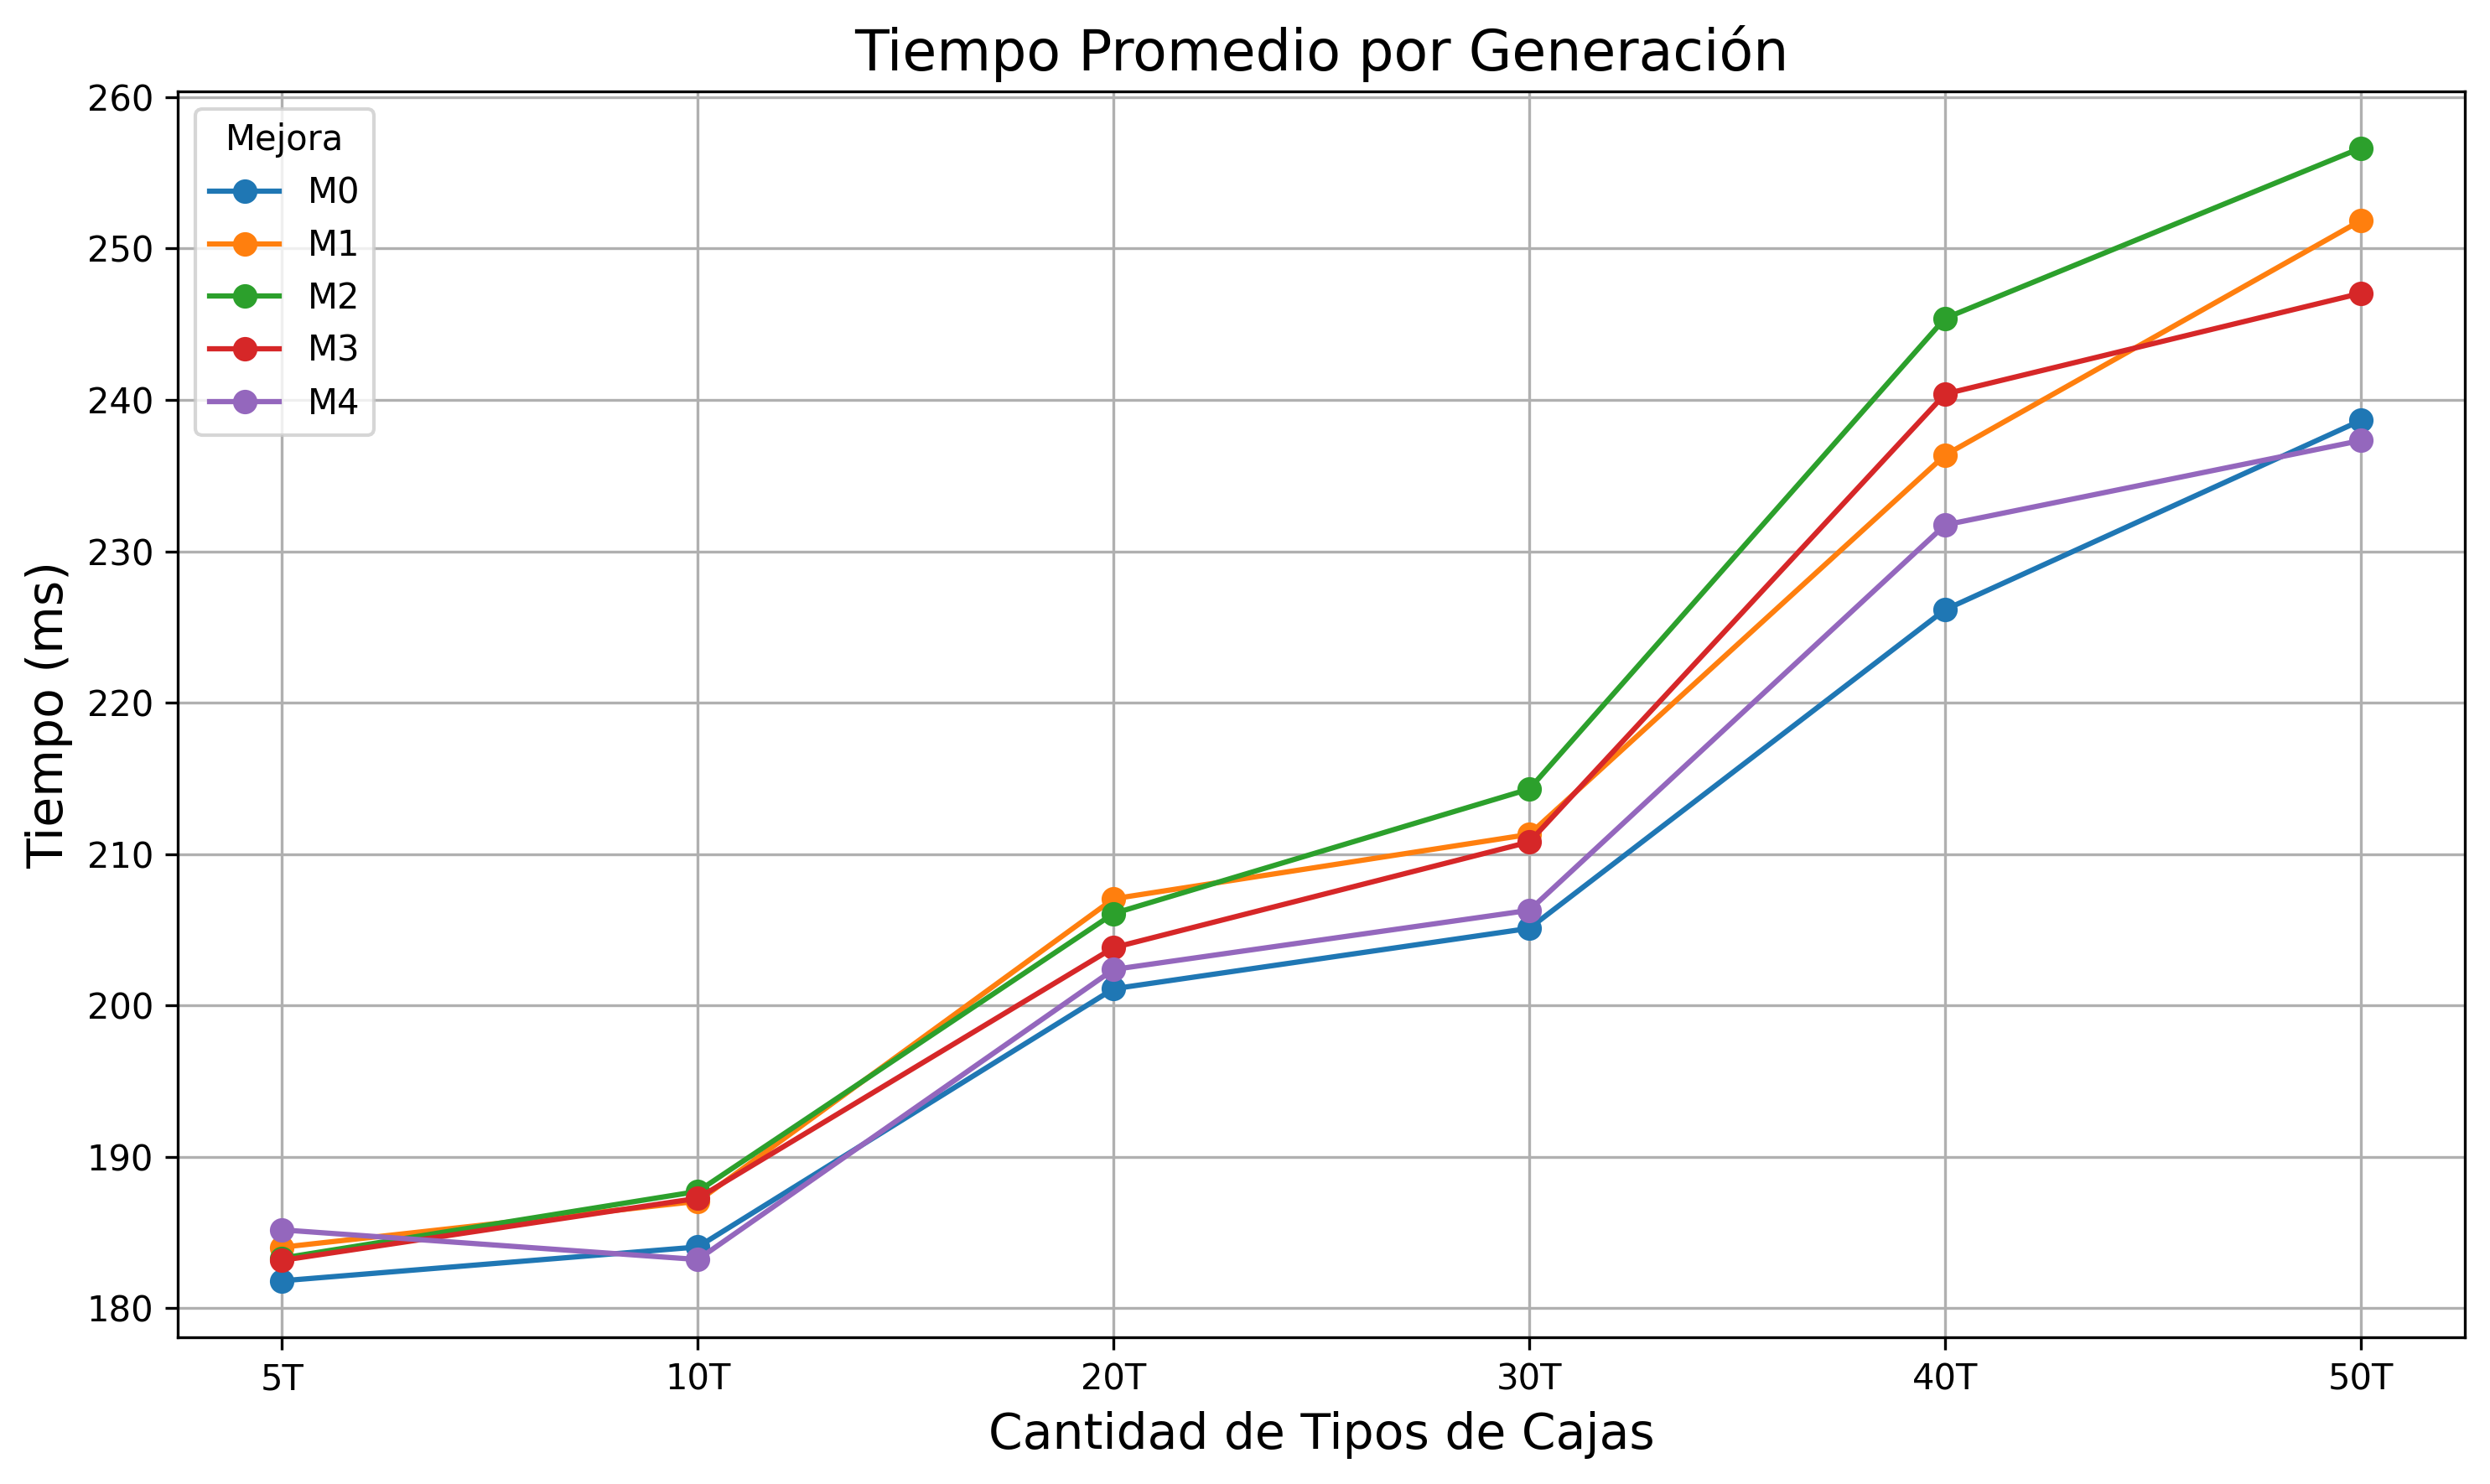

In [10]:
tiempo_iteracion = {}
for r in results:
    types_count = str(r['types_count'])+'T'
    group_improvement = mejoras[r['group_improvement']]
    if types_count not in tiempo_iteracion:
        tiempo_iteracion[types_count] = {}
    if group_improvement not in tiempo_iteracion[types_count]:
        tiempo_iteracion[types_count][group_improvement] = []
    tiempo_iteracion[types_count][group_improvement].append(1000*r['timings']['duration']/r['generations'])
for t in tiempo_iteracion:
    for m in tiempo_iteracion[t]:
        tiempo_iteracion[t][m] = np.mean(tiempo_iteracion[t][m])

import matplotlib.pyplot as plt

# Datos proporcionados
data = tiempo_iteracion

# Preparar los datos para el gráfico
categories = list(data.keys())
subcategories = list(data[categories[0]].keys())

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

for subcategory in subcategories:
    values = [data[category][subcategory] for category in categories]
    plt.plot(categories, values, marker='o', label=subcategory)

# Añadir título y etiquetas
plt.title('Tiempo Promedio por Generación', fontsize=16)
plt.xlabel('Cantidad de Tipos de Cajas', fontsize=14)
plt.ylabel('Tiempo (ms)', fontsize=14)
plt.legend(title='Mejora')
plt.grid(True)
plt.tight_layout()

plt.savefig('./lcp/document/Figures/tiempo_generacion.svg', format='svg')
# Mostrar el gráfico
plt.show()


In [11]:
result = results[300]
problem = problems[result['types_count']][result['problem_id']]
box_types = problem.box_types
best_solution = result['best_solution']
#box_types,best_solution

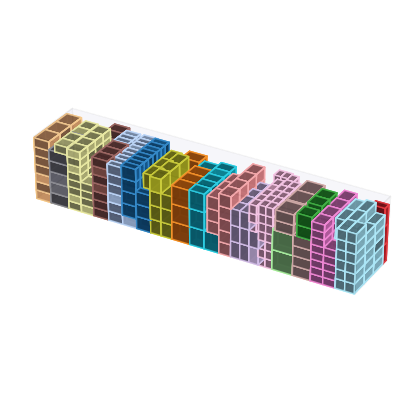

In [12]:
from lcp.src.algorithm.chromosome import Chromosome, Improvement
from lcp.src.algorithm.gene import Gene
from lcp.src.graphic.draw_container import draw

group_improvement = result['group_improvement']

genes = [Gene(type=box_types[b[0]], box_count=b[1], rotation=b[2])
         for b in best_solution]
e = Chromosome(genes=genes, container=problem.container)
imp = Improvement.during if group_improvement == 'during' else Improvement.none
e.evaluate(improvement=imp)
if group_improvement in ['late_all', 'late_best', 'late_some']:
    e.evaluate_with_improvement_late()

draw(e.result, '', problem.container)

In [13]:
winners.keys()

dict_keys(['M2', 'M1', 'M4', 'M0', 'M3'])

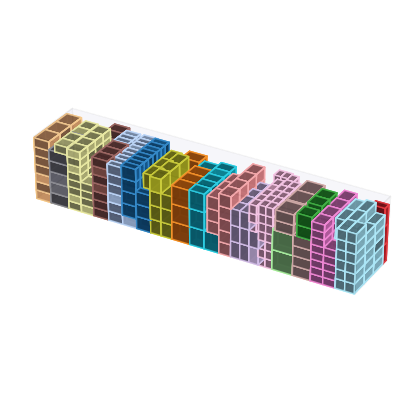

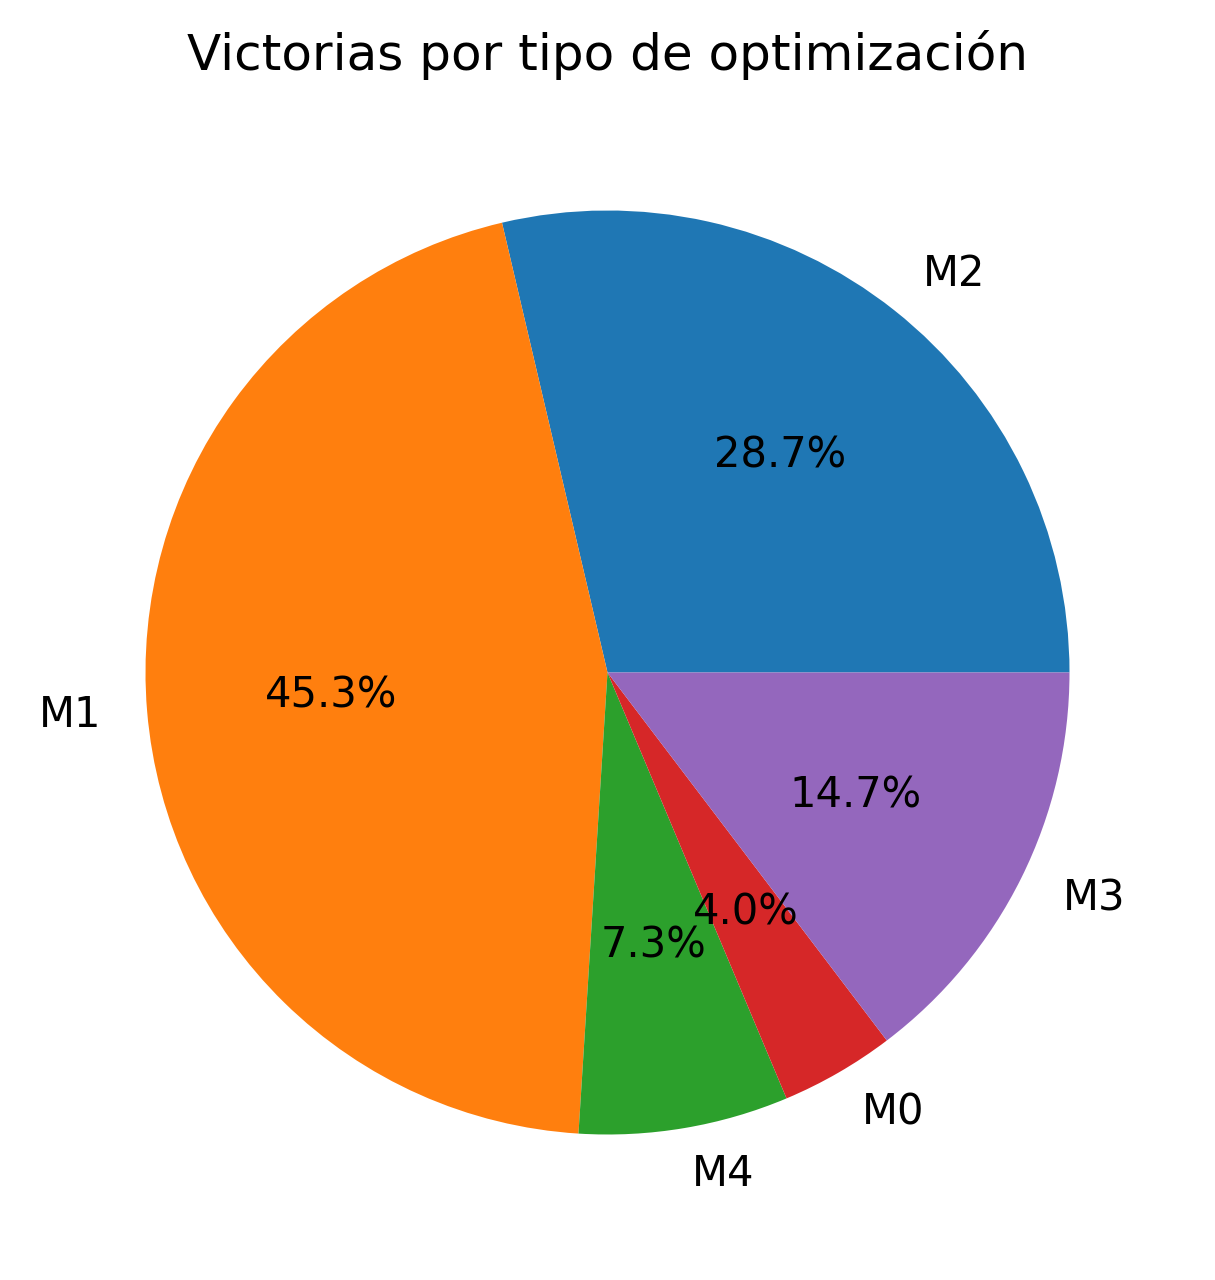

In [14]:
%matplotlib inline
fig, ax = plt.subplots()
ax.pie(winners.values(),
       labels=winners.keys(), autopct='%1.1f%%')
ax.set_title('Victorias por tipo de optimización');

In [15]:
tipos_mejora = list(winners.keys())
cantidad_configuraciones = len(winners['none'])

# Graficar
fig, ax = plt.subplots()

# Iterar sobre cada tipo de mejora y graficar sus valores
for i, tipo in enumerate(tipos_mejora):
    ax.bar([x + i*0.15 for x in range(cantidad_configuraciones)],
           winners[tipo], width=0.15, label=tipo)

# Configurar ejes y leyenda
ax.set_xticks([x + 0.3 for x in range(cantidad_configuraciones)])
ax.set_xticklabels(
    [f'{(i+1)*5}T' for i in range(cantidad_configuraciones)])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Cantidad de victorias')
ax.set_title('Cantidad de victorias por tipo de mejora y tipos de cajas')
ax.legend()

# Mostrar el gráfico
plt.show()

KeyError: 'none'

In [ ]:
types_count = {
    5: [],
    10: [],
    20: [],
}
for r in results:
    types_count[r['types_count']].append(r['generations'])

fig, ax = plt.subplots()
sns.boxplot(data=[types_count[5], types_count[10],
            types_count[20]])
ax.set_xticks(range(5))
ax.set_xticklabels(["5 Tipos", "10 Tipos", "20 Tipos", "30 Tipos", "40 Tipos"])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Generaciones')
ax.set_title('Distribución de generaciones por Tipos de cajas')
plt.show()

In [ ]:
types_count = {
    "none": [],
    "during": [],
    "late_all": [],
    "late_best": [],
    "late_some": []
}

for r in results:
    types_count[r['group_improvement']].append(r['generations'])

fig, ax = plt.subplots()
sns.boxplot(data=[types_count["none"], types_count["during"], types_count["late_all"], types_count["late_best"], types_count["late_some"]])
ax.set_xticks(range(5))
ax.set_xticklabels(["Ninguna", "Durante", "Todas al final", "Mejor al final", "Algunas al final"])
ax.set_xlabel('Tipo de mejora')
ax.set_ylabel('Generaciones')
ax.set_title('Distribución de generaciones por Tipo de Mejora')
plt.show()

In [ ]:
types_count = {
    "none": [],
    "during": [],
    "late_all": [],
    "late_best": [],
    "late_some": []
}

for r in results:
    for t in r['timings']['generations_time']:
        types_count[r['group_improvement']].append(t)

fig, ax = plt.subplots()
sns.boxplot(data=[types_count["none"], types_count["during"], types_count["late_all"], types_count["late_best"], types_count["late_some"]])
ax.set_xticks(range(5))
ax.set_xticklabels(["Ninguna", "Durante", "Todas al final", "Mejor al final", "Algunas al final"])
ax.set_xlabel('Tipo de mejora')
ax.set_ylabel('Tiempo por generación (ms)')
ax.set_title('Distribución de tiempo por generación por tipo de mejora')
plt.show()

In [ ]:
# Cantidad de cajas por tipo de caja

types_count = {
    5: [],
    10: [],
    15: [],
    20: [],
    25: []
}
for r in results:
    types_count[r['types_count']].append(sum([x[1] for x in r['best_solution']]))
    
fig, ax = plt.subplots()
sns.boxplot(data=[types_count[5], types_count[10], types_count[15], types_count[20]])
ax.set_xticks(range(5))
ax.set_xticklabels(["5T", "10T", "15T", "20T", "25T"])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Cantidad de cajas')
ax.set_title('Distribución de cantidad de cajas por tipos de cajas')
plt.show()

In [ ]:
#Gráfico de cantidad de cajas vs generaciones

fig, ax = plt.subplots()
sns.scatterplot(x=[x['types_count'] for x in results], y=[x['generations'] for x in results])
ax.set_xlabel('Tipos de cajas')
ax.set_ylabel('Generaciones')
ax.set_title('Cantidad de cajas vs generaciones')
plt.show()